# a)

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

train = pd.read_csv('stack_stats_2020_train.csv')
test = pd.read_csv('stack_stats_2020_test.csv')

In [3]:
# Stop words
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(document):   
    words = [word for word in document if not word in stop_words]   
    return words

# Stem words
from nltk.stem import PorterStemmer
porter = PorterStemmer()
def stemmer(document):    
    stemmed_document = [porter.stem(word) for word in document]    
    return stemmed_document

# Punctuation
from string import punctuation
def remove_punctuation(document):
    no_punct = ''.join([character for character in document if character not in punctuation])    
    return no_punct

# Remove digits
def remove_digit(document): 
    no_digit = ''.join([character for character in document if not character.isdigit()])         
    return no_digit

[nltk_data] Downloading package punkt to /Users/zhouyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhouyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer

def data_process(df,series,min_df):
    # Remove html
    text = df[series]
    text = text.apply(BeautifulSoup,args=["html.parser"])
    text = text.apply(lambda x: x.get_text())
    text = text.str.replace(r"\n","")
    text = text.str.replace(r"<br/>", "")
    text = text.str.replace(r"\t","")
    
    # Turn to lower case
    text = text.str.lower()
    
    # Remove punctuation
    text = text.apply(remove_punctuation)
    
    # Remove digits
    text = text.apply(remove_digit)
    
    # Tokenization
    text_tokenized = text.apply(word_tokenize)
    
    # Remove stop words
    text_tokenized = text_tokenized.apply(remove_stopwords)
    
    # Stem words
    text_tokenized = text_tokenized.apply(stemmer)

    # Detokenize
    text_detokenized = text_tokenized.apply(TreebankWordDetokenizer().detokenize)
    
    # Document-term Matrix¶
    countvec = CountVectorizer(min_df = min_df) 
    sparse_dtm = countvec.fit_transform(text_detokenized)
    dtm = pd.DataFrame(sparse_dtm.toarray(), columns=countvec.get_feature_names(), index=df.index)
    
    return dtm

In [5]:
train["type"] = "Train"
test["type"] = "Test"
data = pd.concat([train, test])
data = data.reset_index()
data['Useful'] = (data['Score'] >= 1).astype('int32').astype('object')

In [6]:
data.head()

,index,Id,Score,Body,Title,Tags,type,Useful
0,0,495560,1,<p>I have a set of data that I am transforming...,R: emmeans back tranform clr data using clrInv,<r><mixed-model><linear><lsmeans>,Train,1
1,1,489896,0,<p>We are sending a one bit message to someone...,Trying to determine the failure rate of redund...,<probability><python>,Train,0
2,2,497951,2,<p>I am aware that there is a similar post: <a...,How to derive categorical cross entropy update...,<logistic><cross-entropy>,Train,1
3,3,478542,2,<p>I have a Poisson distributed glm where I ha...,"Learning more about glm parameters, how to dig...",<generalized-linear-model><interpretation>,Train,1
4,4,458388,0,<p>1) how do i decide which transformation or ...,Is there I guide to decide which transformatio...,<python><data-transformation><dataset><feature...,Train,0


In [7]:
# Body part
dtm1 = data_process(data, "Body", 0.05)
for label in dtm1.columns:
    dtm1 = dtm1.rename(columns = {label:label+'_body'})
data2 = data.merge(dtm1,left_index=True,right_index=True)
data2 = data2.drop(['index','Body'],axis=1)
data2.head()

,Id,Score,Title,Tags,type,Useful,abl_body,actual_body,algorithm_body,also_body,...,vector_body,want_body,way_body,weight_body,well_body,whether_body,without_body,wonder_body,work_body,would_body
0,495560,1,R: emmeans back tranform clr data using clrInv,<r><mixed-model><linear><lsmeans>,Train,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,489896,0,Trying to determine the failure rate of redund...,<probability><python>,Train,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,497951,2,How to derive categorical cross entropy update...,<logistic><cross-entropy>,Train,1,0,0,0,0,...,3,0,0,0,0,0,0,0,0,1
3,478542,2,"Learning more about glm parameters, how to dig...",<generalized-linear-model><interpretation>,Train,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,458388,0,Is there I guide to decide which transformatio...,<python><data-transformation><dataset><feature...,Train,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [8]:
# Title part
dtm2 = data_process(data,'Title',0.01)
for label in dtm2.columns:
    dtm2 = dtm2.rename(columns = {label:label + '_title'})
data3 = data2.merge(dtm2,left_index=True,right_index=True)
data3 = data3.drop(['Title'],axis=1)
data3.head()

,Id,Score,Tags,type,Useful,abl_body,actual_body,algorithm_body,also_body,analysi_body,...,two_title,understand_title,use_title,valid_title,valu_title,variabl_title,varianc_title,vs_title,way_title,weight_title
0,495560,1,<r><mixed-model><linear><lsmeans>,Train,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,489896,0,<probability><python>,Train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,497951,2,<logistic><cross-entropy>,Train,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,478542,2,<generalized-linear-model><interpretation>,Train,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,458388,0,<python><data-transformation><dataset><feature...,Train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Tag part
data3['Tags'] = data3['Tags'].str.replace(r"<|>|-", " ")
dtm3 = data_process(data3,'Tags',0.01)
for label in dtm3.columns:
    dtm3 = dtm3.rename(columns = {label:label+'_tags'})
data4 = data3.merge(dtm3,left_index=True,right_index=True)
data4 = data4.drop(['Tags'],axis=1)
data4 = data4.drop(['Score','Id'],axis=1)
data4.head()

,type,Useful,abl_body,actual_body,algorithm_body,also_body,analysi_body,anoth_body,answer_body,anyon_body,...,studi_tags,surviv_tags,test_tags,theori_tags,time_tags,transform_tags,valid_tags,valu_tags,variabl_tags,varianc_tags
0,Train,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Train,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,Train,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Train,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Train,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# Training set and test test
train = data4[data4["type"] == "Train"].drop("type",axis=1)
test = data4[data4["type"] == "Test"].reset_index().drop(["index","type"], axis=1)

train_x = train.drop(['Useful'],axis=1)
train_y = train['Useful'].astype('int')

test_x = test.drop(['Useful'],axis=1)
test_y = test['Useful'].astype('int')

# b)

## Baseline Model

In [11]:
print(train_y.value_counts())
print(test_y.value_counts())

0    9684
1    9563
Name: Useful, dtype: int64
0    4226
1    4023
Name: Useful, dtype: int64


In [12]:
print('ACC of Baseline Model is:', 4226/(4226 + 4023))

ACC of Baseline Model is: 0.5123045217602133


## Decision Tree Classifier with CV

In [13]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(train_x,train_y)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred_cart = dtc.predict(test_x)
cm = confusion_matrix(test_y, y_pred_cart)
print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", accuracy_score(test_y, y_pred_cart))

Confusion Matrix: 
 [[2225 2001]
 [1984 2039]]

Accuracy: 0.5169111407443326


## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_x, train_y)

y_pred_rf = rf.predict(test_x)
cm = confusion_matrix(test_y, y_pred_rf)
print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", accuracy_score(test_y, y_pred_rf))

Confusion Matrix: 
 [[2497 1729]
 [1886 2137]]

Accuracy: 0.5617650624318099


## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_x, train_y)

y_prob = logreg.predict_proba(test_x)
y_pred_lr = pd.Series([1 if x > 0.5 else 0 for x in y_prob[:,1]], index=test_y.index)

cm = confusion_matrix(test_y, y_pred_lr)
print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", accuracy_score(test_y, y_pred_lr))

Confusion Matrix: 
 [[2590 1636]
 [1956 2067]]

Accuracy: 0.5645532791853558


/Users/zhouyi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## LDA

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(train_x, train_y)

y_pred_lda = lda.predict(test_x)
cm = confusion_matrix(test_y, y_pred_lda)
print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", accuracy_score(test_y, y_pred_lda))

Confusion Matrix: 
 [[2597 1629]
 [1978 2045]]

Accuracy: 0.5627348769547824


## Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(train_x, train_y)

y_pred_gbc = gbc.predict(test_x)
cm = confusion_matrix(test_y, y_pred_gbc)
print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", accuracy_score(test_y, y_pred_gbc))

Confusion Matrix: 
 [[2834 1392]
 [2143 1880]]

Accuracy: 0.5714632076615347


Based on the accuracy of the above models, I will choose the boosting model because it has the highest accuracy.

In [18]:
def fpr(predictions,test_y,train_y):
    tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
    return fp / (fp + tn)

def tpr(predictions,test_y,train_y):
    tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
    return tp / (tp + fn)

def accuracy(predictions,test_y,train_y):
    acc = accuracy_score(test_y, predictions)
    return acc

def bootstrap_validation(test_data, test_label, train_label, model, metrics_list, sample=500, random_state=66):
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_predicted,bs_label,train_label)
    output_df = pd.DataFrame(output_array)
    return output_df

In [19]:
bs_output_gbc = bootstrap_validation(test_x,test_y,train_y,gbc,
                                 metrics_list=[accuracy,tpr,fpr],
                                 sample = 1000)

bs_gbc_acc_mean = bs_output_gbc.mean()

print('The bootstrapped accuracy of boosting model is '+str(float(bs_gbc_acc_mean[0])))
print('The bootstrapped TPR of boosting model is '+str(float(bs_gbc_acc_mean[1])))
print('The bootstrapped FPR of boosting model is '+str(float(bs_gbc_acc_mean[2])))

(1000, 3)
The bootstrapped accuracy of boosting model is 0.5714506000727364
The bootstrapped TPR of boosting model is 0.4670228200611071
The bootstrapped FPR of boosting model is 0.3290481638365954


(-0.05, 0.05)

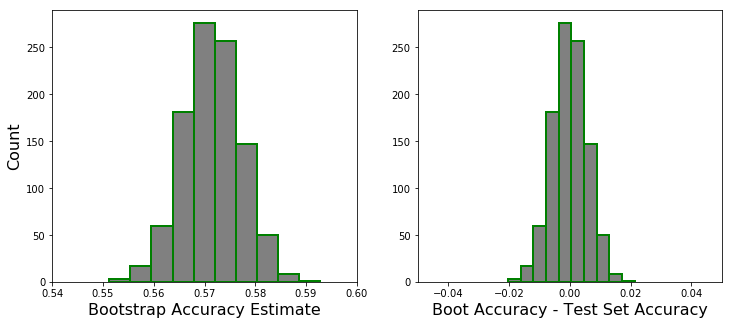

In [20]:
import matplotlib.pyplot as plt

test_acc = accuracy(y_pred_gbc,test_y,train_y)

fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap Accuracy Estimate', fontsize=16)
axs[1].set_xlabel('Boot Accuracy - Test Set Accuracy', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output_gbc.iloc[:,0], bins=10,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.54,0.6])
axs[1].hist(bs_output_gbc.iloc[:,0]-test_acc, bins=10,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.05,0.05])

# c)

## i)

From the baseline model, we can see that about 51.2% of the questions are useful, which means that if we follow the Stack Overflow's current policy that they assign the problem according to the timestamp, the probability that the top question is useful is 51.2%.  
Now we would like to rearrange the questions order, then the probability that the top question is useful is actually equivalent to the probability that the question is literally useful given that our model predict it to be useful.  
Given the confusion matrix, the probability we wanna calculate is the precision of the model. (The formula of which is $\frac{TP}{TP+FP}$ 
I would like to select a model with the highest precision


## ii）

First of all, I calculate the corresponding precision of the models mentioned above given their confusion matrix.  
The precision of CART model is $\frac{2039}{2039+2001} = 50.47\%$  
The precision of Random Forest model is $\frac{2137}{2137+1729} = 55.28\%$.   
The precision of Logistic Regression model is $\frac{2067}{2067+1636} = 55.82\%$.   
The precision of LDA model is $\frac{2045}{2045+1629} = 55.66\%$.   
The precision of Boosting model is $\frac{1880}{1880+1392} = 57.46\%$. 

It seems that the boosting model has the highest precision among all models. In this case, we don't wanna tune any other hyperparameters in the models, however, we may change the threshold of the logistic regression model to get a better precision score.

In order to change the threshold, we need to be careful about it. Given the back-of-the-envelope theory, given 15 related questions, the number of useful questions 'on average' is 8. And, we know that most users are extremely impatient and will only pay attention to the single question. Then we would like to have at least 1 positive predictions out of these averaged 8 useful questions. Thus the TPR should be $TPR >= \frac{1}{8} = 0.125$

Recall the logistic regression in the case of p=0.5

In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_x, train_y)

y_prob = logreg.predict_proba(test_x)
y_pred_lr = pd.Series([1 if x > 0.5 else 0 for x in y_prob[:,1]], index=test_y.index)

cm = confusion_matrix(test_y, y_pred_lr)
print ("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[2590 1636]
 [1956 2067]]


/Users/zhouyi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
threshold = []
precision = []
TPR = []

for p in np.unique(logreg.predict_proba(test_x)[:,1]):
    threshold.append(p)
    y_pred1 = (logreg.predict_proba(test_x)[:,1]>=p).astype(int)
    tn, fp, fn, tp = confusion_matrix(test_y, y_pred1).ravel()
    pre = tp/(tp+fp)
    tpr = tp / (tp + fn)
    precision.append(pre)
    TPR.append(tpr)

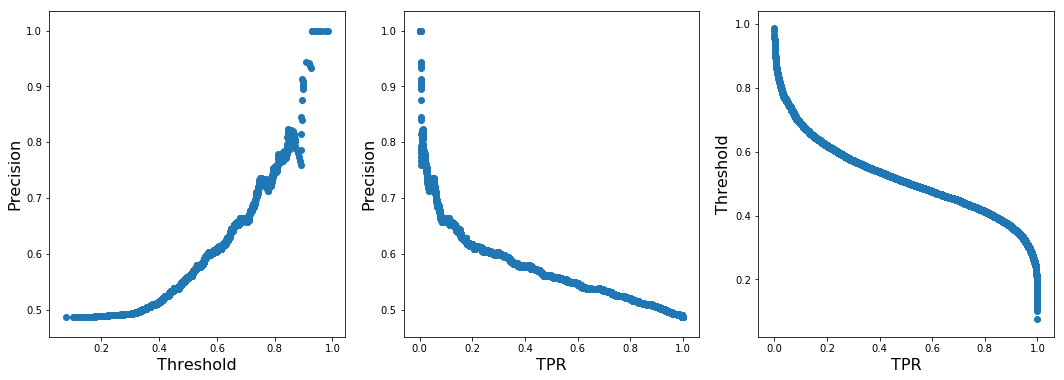

In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
axs[0].set_xlabel('Threshold', fontsize=16)
axs[1].set_xlabel('TPR', fontsize=16)
axs[2].set_xlabel('TPR', fontsize=16)
axs[0].set_ylabel('Precision', fontsize=16)
axs[1].set_ylabel('Precision', fontsize=16)
axs[2].set_ylabel('Threshold', fontsize=16)
axs[0].scatter(threshold,precision)
axs[1].scatter(TPR,precision)
axs[2].scatter(TPR,threshold)

For the case p=0.5, we have already conducted that TPR>=0.125. And we see from the middle graph that when TPR is rather low, the precision(our measure metric) is quite high but not stable, and precision will decrease with an increase in the TPR. We have already have the lower bound of the TPR and we will round it up to 0.2 in this case, which leads to an approximate 0.6 threshold. We will re-train our logistic model with the threshold being 0.6.

In [27]:
logreg2 = LogisticRegression()
logreg2.fit(train_x, train_y)

y_prob2 = logreg2.predict_proba(test_x)
y_pred_lr2 = pd.Series([1 if x > 0.6 else 0 for x in y_prob2[:,1]], index=test_y.index)

cm = confusion_matrix(test_y, y_pred_lr2)
print ("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[3605  621]
 [3066  957]]


/Users/zhouyi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The precision of this model is $\frac{957}{957+621} = 60.65\%$  
Therefore, based on our analysis, the increase in the probability of the top question being truly useful is about $60.65\% - 51.2\% = 9.45\%$